In [1]:
#tensorflow 버전 확인
import tensorflow as tf
print(tf.__version__)

2.6.0


In [2]:
# device list에 GPU있나 확인
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2417776519215604
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7799308288
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17557477526582517395
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:01:00.0, compute capability: 8.6"
]


In [3]:
#라이브러리 설치
!pip install transformers
!pip install keras==2.6

!pip install scikit-learn

#필요한 모듈 불러오기
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification,utils

# attention mask 시각화를 위한 모듈
from bertviz import model_view
utils.logging.set_verbosity_error()

from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd

from tabulate import tabulate
from tqdm import trange
import random
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')


print("GPU available:",torch.cuda.is_available())

GPU available: True


In [51]:
# 내 깃허브 폴더에서 리뷰 데이터 불러와서 dataframe으로 저장
# Price 속성 리뷰
url='https://raw.githubusercontent.com/Eunjin3395/graduation_project/main/data/price_total.csv'
df = pd.read_csv(url,sep=',', header=0, encoding_errors='ignore')
df.head(5)

,id,text,category,polarity
0,1476493:3,"When you add it all together, it just doesn't ...",price,0
1,2156,The bagels are also reasonably priced for NYC.,price,1
2,2424,"It's true, this place is not cheap.",price,0
3,Z#3:2,"I paid just about $60 for a good meal, though :)",price,1
4,2645,BUt their best dish is thh Thai spiced curry n...,price,1


In [52]:
df.dtypes

id          object
text        object
category    object
polarity     int64
dtype: object

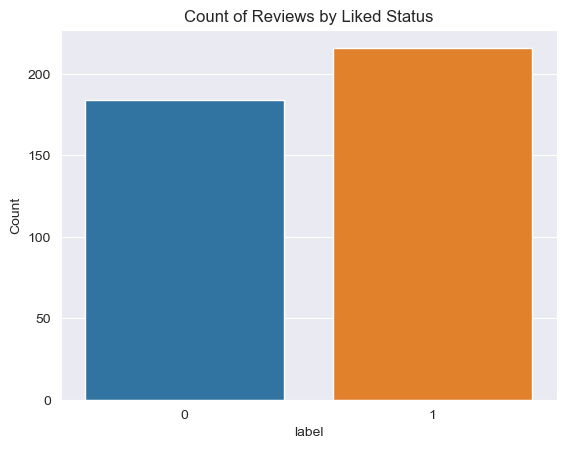

In [53]:
# review data의 label 분포
sns.set_style('darkgrid')

# Create a count plot of the "Liked" column
sns.countplot(x='polarity', data=df)

# Set the title of the plot
plt.title('Count of Reviews by Liked Status')

# Set the label for the x-axis
plt.xlabel('label')

# Set the label for the y-axis
plt.ylabel('Count')

# Show the plot
plt.show()

In [55]:
count_neg = len(df[df['polarity'] == 0])
count_pos=len(df[df['polarity'] == 1])
print("positive: {}, negative: {}".format(count_pos,count_neg))

positive: 216, negative: 184


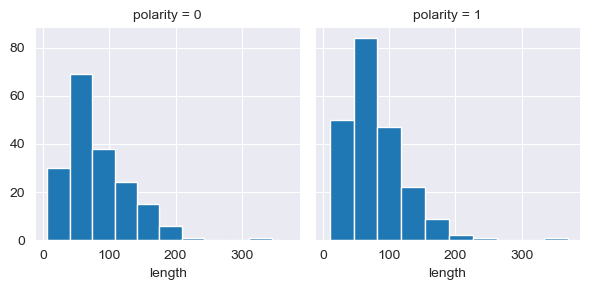

In [6]:
# review data의 길이 분포 및 통계
df_new=df
df_new['length'] = df['text'].apply(len)

# Create a FacetGrid object with 'Liked' as the column to be used for separating the data
# FacetGrid is a grid of subplots that displays the same relationship between different subsets of your data.
g = sns.FacetGrid(df, col='polarity')

# Use the FacetGrid object to plot a histogram of the 'Length' column for each value of 'Liked'
g.map(plt.hist, 'length');

In [7]:
df_new.length.describe()

count    400.000000
mean      79.477500
std       47.393616
min        6.000000
25%       47.000000
50%       70.000000
75%      102.000000
max      370.000000
Name: length, dtype: float64

In [8]:
text = df.text.values
labels = df.polarity.values

In [9]:
# 전처리
tokenizer = BertTokenizer.from_pretrained(
    'bert-base-uncased',
    do_lower_case = True
    )

In [10]:
MAX_LENGTH=150
token_id = []
attention_masks = []

def preprocessing(input_text, tokenizer,max_len_input=MAX_LENGTH):
  '''
  Returns <class transformers.tokenization_utils_base.BatchEncoding> with the following fields:
    - input_ids: list of token ids
    - token_type_ids: list of token type ids
    - attention_mask: list of indices (0,1) specifying which tokens should considered by the model (return_attention_mask = True).
  '''
  return tokenizer.encode_plus(
                        input_text,
                        add_special_tokens = True,
                        max_length = max_len_input,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt',
                        truncation=True
                   )


for sample in text:
  encoding_dict = preprocessing(sample, tokenizer)

  # token_id 리스트 추출
  token_id.append(encoding_dict['input_ids']) 
  # attention_mask 리스트 추출
  attention_masks.append(encoding_dict['attention_mask'])


# 리스트를 텐서로
token_id = torch.cat(token_id, dim = 0)
attention_masks = torch.cat(attention_masks, dim = 0)
labels = torch.tensor(labels)

In [11]:
VAL_RATIO= 0.2
batch_size = 8 # 16 or 32 추천이라고 한다

# Indices of the train and validation splits stratified by labels
train_idx, val_idx = train_test_split(
    np.arange(len(labels)),
    test_size = VAL_RATIO,
    shuffle = True,
    stratify = labels)

# Train and validation sets
train_set = TensorDataset(token_id[train_idx], 
                          attention_masks[train_idx], 
                          labels[train_idx])

val_set = TensorDataset(token_id[val_idx], 
                        attention_masks[val_idx], 
                        labels[val_idx])

# Prepare DataLoader
train_dataloader = DataLoader(
            train_set,
            sampler = RandomSampler(train_set),
            batch_size = batch_size
        )

validation_dataloader = DataLoader(
            val_set,
            sampler = SequentialSampler(val_set),
            batch_size = batch_size
        )


print("train: {}".format(len(train_idx)))
print("validation: {}".format(len(val_idx)))


train: 320
validation: 80


In [12]:

def b_tp(preds, labels):
  '''Returns True Positives (TP): count of correct predictions of actual class 1'''
  return sum([preds == labels and preds == 1 for preds, labels in zip(preds, labels)])

def b_fp(preds, labels):
  '''Returns False Positives (FP): count of wrong predictions of actual class 1'''
  return sum([preds != labels and preds == 1 for preds, labels in zip(preds, labels)])

def b_tn(preds, labels):
  '''Returns True Negatives (TN): count of correct predictions of actual class 0'''
  return sum([preds == labels and preds == 0 for preds, labels in zip(preds, labels)])

def b_fn(preds, labels):
  '''Returns False Negatives (FN): count of wrong predictions of actual class 0'''
  return sum([preds != labels and preds == 0 for preds, labels in zip(preds, labels)])

def b_metrics(preds, labels):
  '''
  Returns the following metrics:
    - accuracy    = (TP + TN) / N
    - precision   = TP / (TP + FP)
    - recall      = TP / (TP + FN)
    - specificity = TN / (TN + FP)
  '''
  preds = np.argmax(preds, axis = 1).flatten()
  labels = labels.flatten()
  tp = b_tp(preds, labels)
  tn = b_tn(preds, labels)
  fp = b_fp(preds, labels)
  fn = b_fn(preds, labels)
  b_accuracy = (tp + tn) / len(labels)
  b_precision = tp / (tp + fp) if (tp + fp) > 0 else 'nan'
  b_recall = tp / (tp + fn) if (tp + fn) > 0 else 'nan'
  b_specificity = tn / (tn + fp) if (tn + fp) > 0 else 'nan'
  return b_accuracy, b_precision, b_recall, b_specificity

In [16]:
# BERT 모델 불러오기
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels = 2,
    output_attentions = True,
    output_hidden_states = False,
)


optimizer = torch.optim.AdamW(model.parameters(), 
                              lr = 5e-5, # learning rate 설정
                              eps = 1e-08
                              )

model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [17]:
# GPU로 학습하도록 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 학습 횟수 설정
epochs = 10

idx=0
epo_list=[]
train_loss_list=[]
val_accuracy_list=[]

for _ in trange(epochs, desc = 'Epoch'):
    idx+=1
    epo_list.append(idx)

    # ========== Training ==========
    model.train()
    
    # Tracking variables
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0

    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        optimizer.zero_grad()
        # Forward pass
        train_output = model(b_input_ids, 
                             token_type_ids = None, 
                             attention_mask = b_input_mask, 
                             labels = b_labels)
        # Backward pass
        train_output.loss.backward()
        optimizer.step()
        # Update tracking variables
        tr_loss += train_output.loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

    # ========== Validation ==========
    model.eval()

    # Tracking variables 
    val_accuracy = []
    val_precision = []
    val_recall = []
    val_specificity = []

    for batch in validation_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
          # Forward pass
          eval_output = model(b_input_ids, 
                              token_type_ids = None, 
                              attention_mask = b_input_mask)
        logits = eval_output.logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        # Calculate validation metrics
        b_accuracy, b_precision, b_recall, b_specificity = b_metrics(logits, label_ids)
        val_accuracy.append(b_accuracy)
        # Update precision only when (tp + fp) !=0; ignore nan
        if b_precision != 'nan': val_precision.append(b_precision)
        # Update recall only when (tp + fn) !=0; ignore nan
        if b_recall != 'nan': val_recall.append(b_recall)
        # Update specificity only when (tn + fp) !=0; ignore nan
        if b_specificity != 'nan': val_specificity.append(b_specificity)

    print('\n\t - Train loss: {:.4f}'.format(tr_loss / nb_tr_steps))
    print('\t - Validation Accuracy: {:.4f}'.format(sum(val_accuracy)/len(val_accuracy)))
    val_accuracy_temp=sum(val_accuracy)/len(val_accuracy)
    train_loss_list.append(round(tr_loss / nb_tr_steps,4))
    val_accuracy_list.append(round(val_accuracy_temp,4))
    #print('\t - Validation Precision: {:.4f}'.format(sum(val_precision)/len(val_precision)) if len(val_precision)>0 else '\t - Validation Precision: NaN')
    #print('\t - Validation Recall: {:.4f}'.format(sum(val_recall)/len(val_recall)) if len(val_recall)>0 else '\t - Validation Recall: NaN')
    #print('\t - Validation Specificity: {:.4f}\n'.format(sum(val_specificity)/len(val_specificity)) if len(val_specificity)>0 else '\t - Validation Specificity: NaN')


Epoch:  10%|███████▌                                                                    | 1/10 [00:03<00:28,  3.17s/it]


	 - Train loss: 0.5474
	 - Validation Accuracy: 0.7875


Epoch:  20%|███████████████▏                                                            | 2/10 [00:06<00:24,  3.03s/it]


	 - Train loss: 0.2780
	 - Validation Accuracy: 0.8250


Epoch:  30%|██████████████████████▊                                                     | 3/10 [00:09<00:20,  2.98s/it]


	 - Train loss: 0.1546
	 - Validation Accuracy: 0.8625


Epoch:  40%|██████████████████████████████▍                                             | 4/10 [00:11<00:17,  2.96s/it]


	 - Train loss: 0.0600
	 - Validation Accuracy: 0.8500


Epoch:  50%|██████████████████████████████████████                                      | 5/10 [00:14<00:14,  2.96s/it]


	 - Train loss: 0.1276
	 - Validation Accuracy: 0.7500


Epoch:  60%|█████████████████████████████████████████████▌                              | 6/10 [00:17<00:11,  2.95s/it]


	 - Train loss: 0.0675
	 - Validation Accuracy: 0.8750


Epoch:  70%|█████████████████████████████████████████████████████▏                      | 7/10 [00:20<00:08,  2.95s/it]


	 - Train loss: 0.0575
	 - Validation Accuracy: 0.8875


Epoch:  80%|████████████████████████████████████████████████████████████▊               | 8/10 [00:23<00:05,  2.95s/it]


	 - Train loss: 0.0196
	 - Validation Accuracy: 0.8750


Epoch:  90%|████████████████████████████████████████████████████████████████████▍       | 9/10 [00:26<00:02,  2.95s/it]


	 - Train loss: 0.0170
	 - Validation Accuracy: 0.8625


Epoch: 100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:29<00:00,  2.97s/it]


	 - Train loss: 0.0160
	 - Validation Accuracy: 0.8250


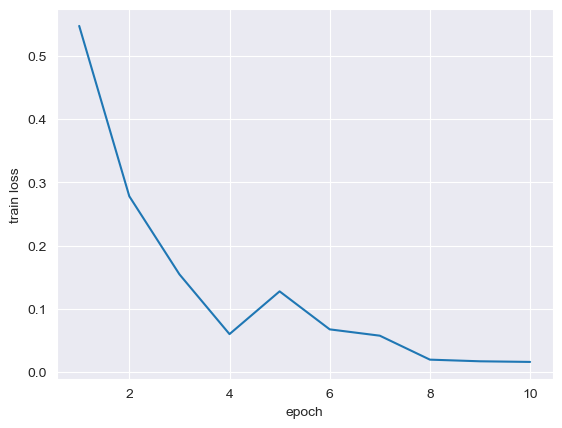

In [18]:
# train loss 그래프
plt.plot(epo_list, train_loss_list)
plt.xlabel('epoch')
plt.ylabel('train loss')
plt.show()

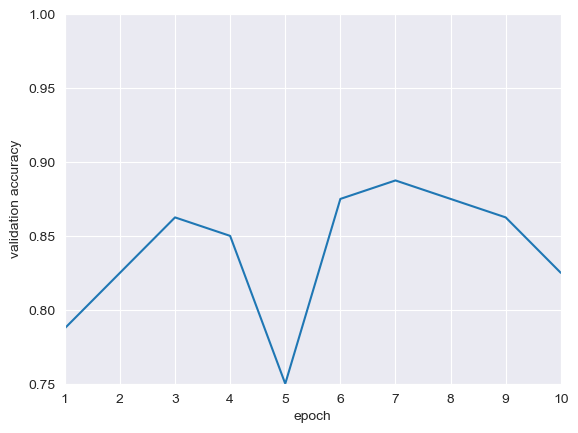

In [19]:
plt.plot(epo_list, val_accuracy_list)
plt.xlabel('epoch')
plt.ylabel('validation accuracy')
plt.axis([1,epochs , 0.75, 1])
plt.show()

In [20]:
#새로운 리뷰를 분류해보자

def test_sentence(sentence):
    # 토큰 ID와 attention mask를 위한 리스트
    test_ids = []
    test_attention_mask = []

    # 전처리
    encoding = preprocessing(sentence, tokenizer)
    test_ids.append(encoding['input_ids'])
    test_attention_mask.append(encoding['attention_mask'])
    test_ids = torch.cat(test_ids, dim = 0)
    test_attention_mask = torch.cat(test_attention_mask, dim = 0)
    
    # Forward pass, calculate logit predictions
    with torch.no_grad():
        output = model(test_ids.to(device), token_type_ids = None, attention_mask = test_attention_mask.to(device))

    prediction = 'Positive' if np.argmax(output.logits.cpu().numpy()).flatten().item() == 1 else 'Negative'
    return prediction
    

    
    
new_sentence ='The food was bad, but it was cheap'
# 'It''s good, but the owner is so unkind. Some of the plates didn''t clean properly because there was something on them. But it''s cost-effective.'





print('입력 문장:', new_sentence)
print('분류:', test_sentence(new_sentence))

입력 문장: The food was bad, but it was cheap
분류: Negative


In [43]:
#test data 세팅

# 내 깃허브 폴더에서 리뷰 데이터 불러와서 dataframe으로 저장
test_url='https://raw.githubusercontent.com/Eunjin3395/graduation_project/main/data/price_test.csv'
df = pd.read_csv(test_url,sep=',', header=0, encoding_errors='ignore')
df.head(5)

,id,text,category,polarity
0,en_SnoozeanAMEatery_480171723:7,The pancakes were certainly inventive but $8.5...,price,0
1,32899414#512291#3,Cuisine is billed as asian fusion - doesn't me...,price,0
2,13383936#420974#1,I found the food to be just as good as its own...,price,1
3,11538980#1053497#4,But make sure you have enough room on your cre...,price,0
4,32889544#0#0,A mix of students and area residents crowd int...,price,1


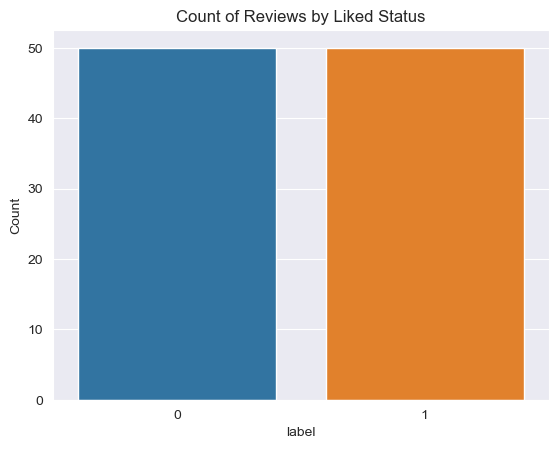

In [50]:
# review data의 label 분포
sns.set_style('darkgrid')

# Create a count plot of the "Liked" column
sns.countplot(x='polarity', data=df)

# Set the title of the plot
plt.title('Count of Reviews by Liked Status')

# Set the label for the x-axis
plt.xlabel('label')

# Set the label for the y-axis
plt.ylabel('Count')

# Show the plot
plt.show()

In [44]:
count=0

test_text = df.text.values
test_labels = df.polarity.values

wrongResult=[]

for i in range(len(test_labels)):
    t = df.iloc[i].text
    color_s='\033[31m' 
    color_e='\033[0m'
    
    prediction=test_sentence(t)
    if(prediction=="Negative"):
        result=0
    else:
        result=1
        
    if(result==df.iloc[i].polarity):
        count+=1     
        color_s=''
        color_e=''
    else:
        wrongResult.append(t)
    print(color_s+"=============================== Input {} ===============================".format(i+1))
    print(t)
    print("model result:",prediction,"\nanswer:", df.iloc[i].polarity,color_e)
    print("")


print("test accuracy: {:.4f}".format(count/len(test_labels)))
    

=============================== Input 1 ===============================
The pancakes were certainly inventive but $8.50 for 3 - 6" pancakes (one of them was more like 5") in the pancake flight (sample of 3 different pancakes) is well over-priced.
model result: Positive 
answer: 0 

=============================== Input 2 ===============================
Cuisine is billed as asian fusion - doesn't meet the bill.
model result: Negative 
answer: 0 

=============================== Input 3 ===============================
I found the food to be just as good as its owner, Da Silvano, just much less expensive.
model result: Positive 
answer: 1 

=============================== Input 4 ===============================
But make sure you have enough room on your credit card as the bill will leave a big dent in your wallet.
model result: Negative 
answer: 0 

=============================== Input 5 ===============================
A mix of students and area residents crowd into this narrow, barely t

=============================== Input 74 ===============================
Finally let into the store 5 at a time, to buy expensive slices from a harried staff.
model result: Negative 
answer: 0 

=============================== Input 75 ===============================
Excellent food, nice ambience, fairly expensive
model result: Positive 
answer: 0 

=============================== Input 76 ===============================
The wine list is extensive, well priced and covers alot of regions.
model result: Positive 
answer: 1 

=============================== Input 77 ===============================
The food is fantastic, authentic, delicious and very, very affordable.
model result: Positive 
answer: 1 

=============================== Input 78 ===============================
I recommend it for a night when you want to splurge! (it was a bit expensive)
model result: Positive 
answer: 0 

=============================== Input 79 ===============================
I have been here, spent tons of

In [65]:
print(wrongResult)

['I found the food to be just as good as its owner, Da Silvano, just much less expensive.', 'Anywhere else, the prices would be 3x as high!', '– The sushi here is perfectly good, but for $5 a piece, either the slices of fish should be larger, or there should be no pretense that this is a moderately priced restaurant (even for NYC).', 'The most pleasant surprise was the check that did not exceed my expectations as it always happens in most of the places.', ") It's not the best Japanese restaurant in the East Village, but it's a pretty solid one for its modest prices, and worth repeat visits.", 'Good Sushi, High Price', 'In the end our check came to $27 for 4 small pancakes, a breakfast burrito, an orange juice and an iced tea (I had water).', "You're going to drop some coin, but completely worth it, especially if you are looking to impress someone."]


In [36]:
# 개별 문장의 attention 추출하는 함수
def get_attention(encoding):
    # 토큰 ID와 attention mask를 위한 리스트
    test_ids = []
    test_attention_mask = []
    test_ids.append(encoding['input_ids'])
    test_attention_mask.append(encoding['attention_mask'])
    test_ids = torch.cat(test_ids, dim = 0)
    test_attention_mask = torch.cat(test_attention_mask, dim = 0)
    
    
    # Forward pass, calculate logit predictions
    with torch.no_grad():
        model_output = model(test_ids.to(device), token_type_ids = None, attention_mask = test_attention_mask.to(device))
        
    prediction = 'Positive' if np.argmax(model_output.logits.cpu().numpy()).flatten().item() == 1 else 'Negative'
    attention=model_output[-1]
    last_attention=attention[-1]
    tokens=tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])
    
    return attention,last_attention,tokens,prediction

In [24]:
def get_val_len(ids):
    count=0
    for elem in ids:
        if(elem!=0):
            count+=1
    return count

In [37]:
# 개별 문장의 attention 추출
from bertviz import head_view

sent="Terrible service, but cheap and reasonable price."

# 전처리
encoding = preprocessing(sent, tokenizer,10)


retAtt,retLastAtt,retTok,prediction=get_attention(encoding)

print('입력 문장:', sent)
print('분류:', prediction)
print()

head_view(retAtt,retTok)


입력 문장: Terrible service, but cheap and reasonable price.
분류: Positive



<IPython.core.display.Javascript object>

In [38]:
def sort_by_att(attention,tokens):
    '''
        last layer의 attention tensor를 입력 받아 각 token의 attention 값을 head에 대한 평균을 낸 뒤, attention이 높은 token 순으로 idx를 반환하는 함수
    '''
    
    attention=attention[0] # shape: 12,len,len
    
    size=len(tokens)
    
    total_atts_sum=[] # 각 head에 대한 각 토큰의 attention값의 합
    for head in range(0,12):
        att_of_head=attention[head] # 한 head의 attention
        atts_sum_of_head=[0.0]*size # 해당 head 하나의 attention의 합
        for row in att_of_head:
            col=0
            for elem in row:
                value=elem.item()
                atts_sum_of_head[col]+=value # head 하나에 대한 토큰이 가지는 attention 값
                col+=1
        total_atts_sum.append(atts_sum_of_head)
    
    total_sum_value=[0.0]*size
    for elem in total_atts_sum:
        for i in range(0,size):
            total_sum_value[i]+=elem[i]
            

    total_mean=[]
    for elem in total_sum_value:
        total_mean.append(elem/12)
    
    


    idxs=sorted(range(len(total_mean)), key=lambda k: total_mean[k], reverse=True)
    return(idxs)
    

In [39]:
# attention 순서대로 텍스트 배경색 주기
color_code=[
    "\033[48;5;243m",
    "\033[48;5;245m",
    "\033[48;5;247m",
    "\033[48;5;249m",
    "\033[48;5;251m",
    "\033[48;5;253m",
    "\033[48;5;255m"
]
def emp_by_att(attIdxs,tokens):   
    valTokens=[]
    for tok in tokens:
        if(tok!='[CLS]' and tok!='[PAD]' and tok!='[SEP]'):
            valTokens.append(tok)
        
    valIdxs=[]
    for idx in attIdxs:
        if len(valIdxs)==7:
            break;
        
        if(idx>0 and idx<=len(valTokens)):
            if(valTokens[idx-1]!=',' and valTokens[idx-1]!='.'):
                valIdxs.append(idx-1)
    
    resultSent=""
    for i in range(len(valTokens)):
        if(i in valIdxs):
            outTok=color_code[valIdxs.index(i)]+valTokens[i]+"\033[0m"
        else:
            outTok=valTokens[i]
        resultSent+=outTok
        resultSent+=' '
    
    print("========================= emphasize by attention result==========================")
    print(resultSent)

In [40]:
def get_highest_att_tok(idxs,retTok,num):
    count=0
    print("highest attention: ",end="")
    for i in idxs:
        if(i<len(retTok)):
            if(retTok[i]!='[CLS]' and retTok[i]!='[SEP]' and retTok[i]!='.' and retTok[i]!=','):
                if(count<num):
                    print(retTok[i],end=" ")
                    count+=1
                

In [41]:
# 개별 문장을 attention이 높은 token 순으로 보여주기
sort_by_att(retLastAtt,retTok)

emp_by_att(idxs,retTok)

get_highest_att_tok(idxs,retTok,3)

========================= emphasize by attention result==========================
terrible service , but cheap and reasonable price 
highest attention: but price terrible 

In [45]:
#잘못 분류된 문장의 attention
for sent in wrongResult:
    encoding = preprocessing(sent, tokenizer,50)
    MAX_LEN_IN=get_val_len(encoding['input_ids'][0])


    retAtt,retLastAtt,retTok,prediction=get_attention(encoding)

    print('입력 문장:', sent)
    print('분류:', prediction)
    print('MAX_LEN: ',MAX_LEN_IN)
    
    idxs=sort_by_att(retLastAtt,retTok)

    emp_by_att(idxs,retTok)
    
    get_highest_att_tok(idxs,retTok,4)
    print()
    print()
    print()
    print()

입력 문장: The pancakes were certainly inventive but $8.50 for 3 - 6" pancakes (one of them was more like 5") in the pancake flight (sample of 3 different pancakes) is well over-priced.
분류: Positive
MAX_LEN:  48
========================= emphasize by attention result==========================
the pancakes were certainly in ##vent ##ive but $ 8 . 50 for 3 - 6 " pancakes ( one of them was more like 5 " ) in the pan ##cake flight ( sample of 3 different pancakes ) is well over - priced . 
highest attention: in was but the 



입력 문장: Anywhere else, the prices would be 3x as high!
분류: Negative
MAX_LEN:  14
========================= emphasize by attention result==========================
anywhere else , the prices would be 3 ##x as high ! 
highest attention: would ! prices be 



입력 문장: – The sushi here is perfectly good, but for $5 a piece, either the slices of fish should be larger, or there should be no pretense that this is a moderately priced restaurant (even for NYC).
분류: Positive
MAX_LEN:

========================= emphasize by attention result==========================
to start off , approximately 8 - 10 oz of orange juice will cost you $ 3 . 
highest attention: cost approximately will to 



입력 문장: The food was definitely good, but when all was said and done, I just couldn't justify it for the price (including 2 drinks, $100/person)...
분류: Positive
MAX_LEN:  39
========================= emphasize by attention result==========================
the food was definitely good , but when all was said and done , i just couldn ' t justify it for the price ( including 2 drinks , $ 100 / person ) . . . 
highest attention: ' for the i 



입력 문장: The main draw of this place is the price.
분류: Positive
MAX_LEN:  12
========================= emphasize by attention result==========================
the main draw of this place is the price . 
highest attention: price the draw is 



입력 문장: If your looking for nasty high priced food with a dash of ghetto scenery cheap BX A$$ this is the p

In [47]:
#잘못 분류된 문장의 attention
for sent in wrongResult:
    encoding = preprocessing(sent, tokenizer,50)
    MAX_LEN_IN=get_val_len(encoding['input_ids'][0])


    retAtt,retLastAtt,retTok,prediction=get_attention(encoding)

    print('입력 문장:', sent)
    print('분류:', prediction)
    print('MAX_LEN: ',MAX_LEN_IN)
    
    idxs=sort_by_att(retLastAtt,retTok)

    emp_by_att(idxs,retTok)
    
    get_highest_att_tok(idxs,retTok,4)
    print()
    print()
    print()
    print()

입력 문장: The pancakes were certainly inventive but $8.50 for 3 - 6" pancakes (one of them was more like 5") in the pancake flight (sample of 3 different pancakes) is well over-priced.
분류: Positive
MAX_LEN:  48
========================= emphasize by attention result==========================
the pancakes were certainly in ##vent ##ive but $ 8 . 50 for 3 - 6 " pancakes ( one of them was more like 5 " ) in the pan ##cake flight ( sample of 3 different pancakes ) is well over - priced . 
highest attention: in was but the 



입력 문장: Anywhere else, the prices would be 3x as high!
분류: Negative
MAX_LEN:  14
========================= emphasize by attention result==========================
anywhere else , the prices would be 3 ##x as high ! 
highest attention: would ! prices be 



입력 문장: – The sushi here is perfectly good, but for $5 a piece, either the slices of fish should be larger, or there should be no pretense that this is a moderately priced restaurant (even for NYC).
분류: Positive
MAX_LEN:

========================= emphasize by attention result==========================
to start off , approximately 8 - 10 oz of orange juice will cost you $ 3 . 
highest attention: cost approximately will to 



입력 문장: The food was definitely good, but when all was said and done, I just couldn't justify it for the price (including 2 drinks, $100/person)...
분류: Positive
MAX_LEN:  39
========================= emphasize by attention result==========================
the food was definitely good , but when all was said and done , i just couldn ' t justify it for the price ( including 2 drinks , $ 100 / person ) . . . 
highest attention: ' for the i 



입력 문장: The main draw of this place is the price.
분류: Positive
MAX_LEN:  12
========================= emphasize by attention result==========================
the main draw of this place is the price . 
highest attention: price the draw is 



입력 문장: If your looking for nasty high priced food with a dash of ghetto scenery cheap BX A$$ this is the p

In [48]:
#NAVER test data 세팅

# 내 깃허브 폴더에서 리뷰 데이터 불러와서 dataframe으로 저장
test_url='https://raw.githubusercontent.com/Eunjin3395/graduation_project/main/data/naver_data/naver_price_test.csv'
df = pd.read_csv(test_url,sep=',', header=0,encoding="CP949")
df.head(5)

,id,category,text,polarity,trans_text
0,1605,price,가격대는 좀 있네요. 이건물 식당들.\n모임했는데 분위기 괜찮았어요.,0,There's a bit of a price range. The restauran...
1,1192,price,맛은 물론이고 오마카세를 가성비 좋은 가격에 즐기기 좋았습니다 평택에서 스시는 여기...,1,It was good to enjoy omakase at a cost-effecti...
2,175,price,가격도 저렴 하고 맛있어요,1,It's cheap and delicious
3,1666,price,가격이 좀 비싸긴 하지만... 맛있습니다! \n지나갈 때마다 그냥지나치지 못하네요~~,0,"It's a little expensive, but... It's delicious..."
4,1188,price,친구들과 점심 뭐먹을까 찾다가 당일로 예약하고갔습니다~ 하나하나 꼼꼼한 설명과 가격...,1,I was looking for what to eat for lunch with m...


In [49]:
count=0

test_text = df.trans_text.values
test_labels = df.polarity.values

NaverWrongResult=[]

for i in range(len(test_labels)):
    t = df.iloc[i].trans_text
    color_s='\033[31m' 
    color_e='\033[0m'
    
    prediction=test_sentence(t)
    if(prediction=="Negative"):
        result=0
    else:
        result=1
        
    if(result==df.iloc[i].polarity):
        count+=1     
        color_s=''
        color_e=''
    else:
        NaverWrongResult.append(t)
    print(color_s+"=============================== Input {} ===============================".format(i+1))
    print(t)
    print("model result:",prediction,"\nanswer:", df.iloc[i].polarity,color_e)
    print("")


print("test accuracy: {:.4f}".format(count/len(test_labels)))

=============================== Input 1 ===============================
There's a bit of a price range.  The restaurants in this building.. We had a meeting and the atmosphere was good.
model result: Positive 
answer: 0 

=============================== Input 2 ===============================
It was good to enjoy omakase at a cost-effective price as well as the taste This is the best sushi restaurant in Pyeongtaek><
model result: Positive 
answer: 1 

=============================== Input 3 ===============================
It's cheap and delicious
model result: Positive 
answer: 1 

=============================== Input 4 ===============================
It's a little expensive, but... It's delicious. Every time I pass by, I can't just pass by~~
model result: Negative 
answer: 0 

=============================== Input 5 ===============================
I was looking for what to eat for lunch with my friends, and I made a reservation for the day. The atmosphere was good and delicious with 

=============================== Input 41 ===============================
It's the best jokbal ever. It's so good. Even makguksu...!! It's a little expensive, but I'm satisfied with the taste!
model result: Positive 
answer: 0 

=============================== Input 42 ===============================
The interior is clean and kind, and I really enjoyed the meal. The quality is so good for the price. It's the best sushi restaurant in Pyeongtaek
model result: Positive 
answer: 1 

=============================== Input 43 ===============================
Considering the brunch, the price was good and the taste was good
model result: Positive 
answer: 1 

=============================== Input 44 ===============================
It's my first time going to a restaurant, but the food tastes good and the price range is good, so I think it's a good cost-effective restaurant!! Haha
model result: Positive 
answer: 1 

=============================== Input 45 ===============================
The pric

=============================== Input 97 ===============================
It's expensive compared to the waffle menu, but the taste seems to be luxurious because it seems to use inexpensive ingredients.  The taste of chocolate is not cheap, it's like a proper chocolate.
model result: Negative 
answer: 0 

=============================== Input 98 ===============================
The amount is a little small compared to the price, but it's still good, so I'll come back to buy it again! I only ate the famous place in Gangwon-do, but I'm going to clean up the place and the chicken gangjeong is the sweet and sour chicken^^
model result: Negative 
answer: 0 

=============================== Input 99 ===============================
The price is going up Too much
model result: Negative 
answer: 0 

=============================== Input 100 ===============================
The cafe atmosphere is good and the price is cheap, so the food is clean and delicious I want to come again next time
model re